In [ ]:
#@title
# import required libraries

import pandas as pd # dataframes
import numpy as np #mathematical operations

# to visualise

import plotly.express as px # plotly
from wordcloud import WordCloud # wordclouds
import matplotlib.pyplot as plt #matplot
import seaborn as sns #seaborn

# preprocessing 

import re #Regular expressions
import nltk #NLP library
import spacy
import string
from bs4 import BeautifulSoup #HTML tags
from nltk.corpus import stopwords #english stopwords
#lematising
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Vectorisation

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Treating class imbalanced data

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# model building

from sklearn.model_selection import train_test_split

# algorithms

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# checking up with models

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
# landing google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load your dataframe
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Research/Preprocessed.csv",index_col=[0])

In [ ]:
# change both types into string
df['content'] = df['content'].astype('str')
df['fileclass'] = df['fileclass'].astype('str') 

In [ ]:
# Replace DigitalInclusion value with 1
df.loc[df["fileclass"] == "DigitalInclusion", "fileclass"] = 1
df.head(5)

,fileclass,content
0,ChildProtection,trend child sexual abuse material trend child ...
1,ChildProtection,covid remote eliminate female genital mutilati...
2,ChildProtection,journal medium subsequent selfharm followup ch...
3,ChildProtection,original ar sexual exploitation abuse child ph...
4,ChildProtection,covid implication protect child april covid pr...


In [ ]:
# Replace other values with 0
df.loc[df["fileclass"] != 1, "fileclass"] = 0

# reorder the dataframe to get DigitalInfrastructure content to appear first
df = df.sort_values(by='fileclass', ascending=False)


In [ ]:
# check if there are duplicates
df.duplicated(subset=['content']).any() #duplicates

True

In [ ]:
# remove duplicates, leaving the first record
df = df.drop_duplicates(subset=['content'],keep="first")

In [ ]:
# spread of text files after removing duplicates
# Count the number of items per group
group_counts = df.groupby("fileclass").count()
group_counts=group_counts.reset_index()

# Create the bar chart
fig = px.bar(group_counts, x='fileclass', y='content',color="fileclass")

# Show the chart
fig.show()

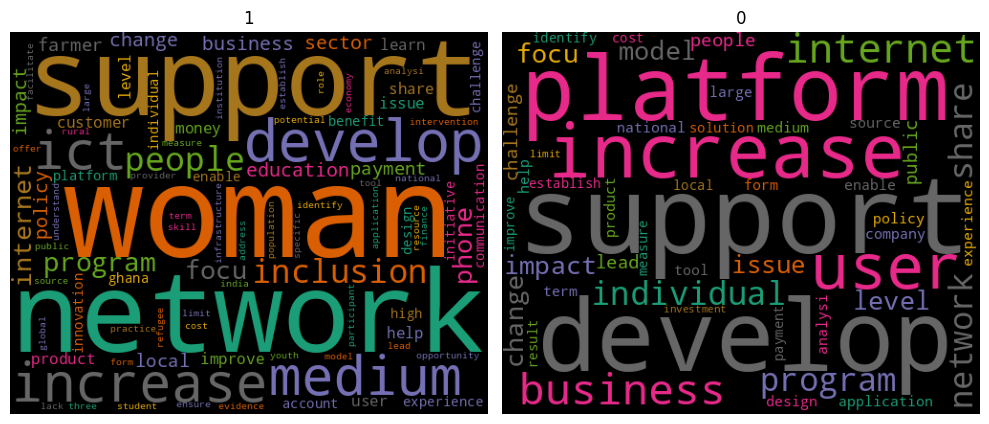

In [ ]:
# word clouds based on intervention areas

# Get all the unique classes in the dataset
classes = df['fileclass'].unique()

# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.ravel()

# Iterate through each class
for i, class_name in enumerate(classes):
    # Get all the text for the current class
    class_text = df[df['fileclass'] == class_name]['content'].str.cat(sep=' ')
    # Generate the wordcloud
    wordcloud = WordCloud(width = 500, height = 400, 
                colormap="Dark2",
                min_font_size = 10).generate(class_text) 
    # Plot the wordcloud
    axs[i].imshow(wordcloud) 
    axs[i].set_title(f"{class_name}") 
    axs[i].axis("off") 
fig.tight_layout()
plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Filter the dataframe to include only class 0 samples
class_0_df = df[df['fileclass'] == 0]

# Concatenate the text data from class 0 samples into a single string
class_0_text = ' '.join(class_0_df['content'])

# Tokenize and filter the text data from class 0 samples
class_0_tokens = nltk.word_tokenize(class_0_text)

# Count the frequency of each word in class 0
class_0_word_freq = nltk.FreqDist(class_0_tokens)

# Filter the dataframe to include only class 1 samples
class_1_df = df[df['fileclass'] == 1]

# Concatenate the text data from class 1 samples into a single string
class_1_text = ' '.join(class_1_df['content'])

# Tokenize and filter the text data from class 1 samples
class_1_tokens = nltk.word_tokenize(class_1_text)

# Count the frequency of each word in class 1
class_1_word_freq = nltk.FreqDist(class_1_tokens)

# Get the keywords that are common in class 1 but not common in class 0
k = 10  # Specify the desired number of keywords
keywords = []

for word, frequency in class_1_word_freq.items():
    if word in class_0_word_freq:
        if frequency > class_0_word_freq[word]:
            keywords.append((word, frequency))

# Sort the keywords by frequency in descending order
keywords.sort(key=lambda x: x[1], reverse=True)


# Print the top keywords
for keyword, frequency in keywords[:k]:
    print(keyword, frequency)

woman 7203
gender 3496
inclusion 3365
men 1402
refugee 1381
icts 1111
womens 790
empowerment 651
disability 632
equality 628


In [ ]:
# vectorsing the content column
vectorizer = TfidfVectorizer(stop_words=None, max_features=300000)
vectorized_df = vectorizer.fit_transform(df['content'])
# defining the y label
y = df['fileclass']
y=y.astype('int')
y=y.to_frame()

In [ ]:
keywords= ['woman','gender','inclusion','men','women','empowerment','disability','equality']

In [ ]:
# Create binary features for each keyword
for keyword in keywords:
    df[keyword] = np.where(df['content'].str.contains(keyword), 1, 0)

In [ ]:
from scipy.sparse import hstack

# Concatenate the binary features with the vectorized features
X = hstack([vectorized_df, df[keywords].values])

In [ ]:
# train test split
X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=75)

In [ ]:
# treat class imbalanced data
ros = RandomOverSampler(random_state=1500)
X_trainro, Y_trainro = ros.fit_resample(X_train, Y_train)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_trainru, Y_trainru = rus.fit_resample(X_train, Y_train)

Random forest

In [ ]:
# fit the model
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, Y_train.values.ravel())

#make predictions
pred_rf = rf.predict(x_test)

#print accuracy
print("Accuracy %s" % accuracy_score(pred_rf,y_test))

Accuracy 0.7621621621621621


In [ ]:
print(classification_report(y_test,pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       142
           1       0.00      0.00      0.00        43

    accuracy                           0.76       185
   macro avg       0.38      0.50      0.43       185
weighted avg       0.59      0.76      0.66       185



Decision Tree

In [ ]:
# fit the model
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, Y_train.values.ravel())

# make predictions
pred_dt = dt.predict(x_test)

# print accuracy 
print("Accuracy %s" % accuracy_score(pred_dt,y_test))

Accuracy 0.7351351351351352


In [ ]:
print(classification_report(y_test,pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       142
           1       0.43      0.47      0.45        43

    accuracy                           0.74       185
   macro avg       0.63      0.64      0.64       185
weighted avg       0.74      0.74      0.74       185



Naive bayes

In [ ]:
# fit the model
nb = MultinomialNB()
nb.fit(X_trainro, Y_trainro.values.ravel())

# make predictions 
pred_nb = nb.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_nb,y_test))

Accuracy 0.5351351351351351


In [ ]:
print(classification_report(y_test,pred_nb))

              precision    recall  f1-score   support

           0       0.95      0.42      0.58       142
           1       0.33      0.93      0.48        43

    accuracy                           0.54       185
   macro avg       0.64      0.67      0.53       185
weighted avg       0.81      0.54      0.56       185



K-Nearest

In [ ]:
# fit the model
knn = KNeighborsClassifier()
knn.fit(X_trainro, Y_trainro.values.ravel())

# make predictions
pred_knn = knn.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_knn,y_test))

Accuracy 0.4864864864864865


In [ ]:
print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.77      0.47      0.59       142
           1       0.23      0.53      0.33        43

    accuracy                           0.49       185
   macro avg       0.50      0.50      0.46       185
weighted avg       0.65      0.49      0.52       185



Logistic

In [ ]:
# fit the model
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, Y_train.values.ravel())

# make predictions
pred_lr = lr.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_lr,y_test))

Accuracy 0.7297297297297297


In [ ]:
print(classification_report(y_test,pred_lr))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       142
           1       0.42      0.44      0.43        43

    accuracy                           0.73       185
   macro avg       0.63      0.63      0.63       185
weighted avg       0.73      0.73      0.73       185



Ada boost

In [ ]:
# fit the model
ab = AdaBoostClassifier()
ab.fit(X_trainro, Y_trainro.values.ravel())

# make predictions
pred_ab = ab.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_ab,y_test))

Accuracy 0.745945945945946


In [ ]:
print(classification_report(y_test,pred_ab))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       142
           1       0.44      0.37      0.41        43

    accuracy                           0.75       185
   macro avg       0.63      0.62      0.62       185
weighted avg       0.73      0.75      0.74       185



SGD

In [ ]:
# fit the model
sgd = SGDClassifier(class_weight='balanced')
sgd.fit(X_train, Y_train.values.ravel())

# make predictions
pred_sgd = sgd.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_sgd,y_test))

Accuracy 0.772972972972973


In [ ]:
print(classification_report(y_test,pred_sgd))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       142
           1       0.54      0.16      0.25        43

    accuracy                           0.77       185
   macro avg       0.66      0.56      0.56       185
weighted avg       0.73      0.77      0.72       185



Support Vector

In [ ]:
# fit the model
svc = SVC()
svc.fit(X_trainro, Y_trainro.values.ravel())

# make predictions
pred_svc = svc.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_svc,y_test))

Accuracy 0.7513513513513513


In [ ]:
print(classification_report(y_test,pred_svc))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       142
           1       0.46      0.40      0.42        43

    accuracy                           0.75       185
   macro avg       0.64      0.63      0.63       185
weighted avg       0.74      0.75      0.74       185



In [ ]:
from sklearn.ensemble import VotingClassifier

# Create instances of the SGDClassifier and RandomForestClassifier
dt = DecisionTreeClassifier(class_weight='balanced')
nb = MultinomialNB()

# Create an instance of the VotingClassifier
ensemble = VotingClassifier(estimators=[('dt', dt), ('nb', nb)], voting='hard')

# Fit the VotingClassifier to the data
ensemble.fit(X_trainro, Y_trainro.values.ravel())

# Make predictions
pred_ensemble = ensemble.predict(x_test)

# Print accuracy
print("Accuracy %s" % accuracy_score(pred_ensemble, y_test))

Accuracy 0.7513513513513513


In [ ]:
print(classification_report(y_test,pred_ensemble))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       142
           1       0.46      0.40      0.42        43

    accuracy                           0.75       185
   macro avg       0.64      0.63      0.63       185
weighted avg       0.74      0.75      0.74       185



Hyperparameter tuning


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the parameter grid for hyperparameter tuning
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
              'fit_prior': [True, False]}

# Create an instance of MultinomialNB
nb = MultinomialNB()

# Create an instance of GridSearchCV
grid_search = GridSearchCV(nb, param_grid, cv=5)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, Y_train.values.ravel())

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'alpha': 0.5, 'fit_prior': False}


In [ ]:
# fit the model
nb = MultinomialNB(alpha= 0.5, fit_prior= False)
nb.fit(X_trainro, Y_trainro.values.ravel())

MultinomialNB(alpha=0.5, fit_prior=False)

In [ ]:
# make predictions on train set
pred_train = nb.predict(X_train)

# check for accuacy
print("Accuracy of training data set %s" % accuracy_score(pred_train,Y_train))

Accuracy of training data set 0.7767441860465116


In [ ]:
# make predictions test set
pred_svch = nb.predict(x_test)

# print accuracy
print("Accuracy of testing data set %s" % accuracy_score(pred_svch,y_test))
# get classification report
print(classification_report(y_test,pred_svch))

Accuracy of testing data set 0.5837837837837838
              precision    recall  f1-score   support

           0       0.89      0.52      0.66       142
           1       0.33      0.79      0.47        43

    accuracy                           0.58       185
   macro avg       0.61      0.66      0.56       185
weighted avg       0.76      0.58      0.61       185



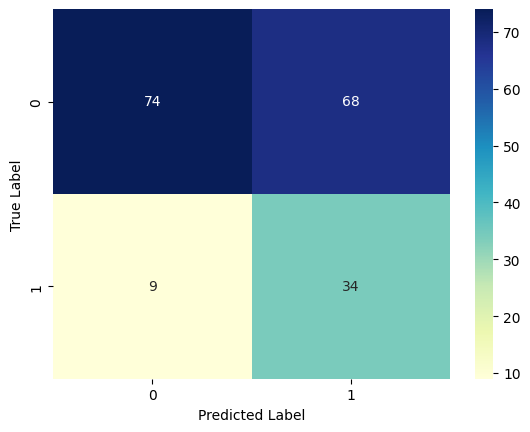

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, pred_svch)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from joblib import Parallel, delayed
import joblib

# Save the model as a pickle in a file
joblib.dump(nb, '/content/drive/MyDrive/Colab Notebooks/Research/digitalinclusion.pkl')

['/content/drive/MyDrive/Colab Notebooks/Research/digitalinclusion.pkl']